# Optimized rule-based control of a solar home

This control scheme is an improvement of the simple [rule-based control](Solar_home_Python_rule-base.ipynb). A extra heuristic rule is added to make better use of the low price period between 00:00 and 06:00. This rules takes grid electricity to bring the battery to a target State of Energy at 06:00. This “precharging” avoids buying electricty during the day or evening, when it is more expensive. However, an excessive precharging may lead to wasted solar power.

Two remarks:
* The idea for the “precharging” heuristic, and the way it is formulated, comes from observations on the optimal control policy obtained with [Stochastic Dynamic Programming](Solar_home_Python_SDP.ipynb) (SDP). Therefore, the performance of this relatively simple control should not be used to discard SDP for being too complex, since SDP was its inspiration!
* It is a parametric strategy because the target State of Energy needs to be optimized based on past scenarios. Therefore, the *training* solar home data should be used, not the *test* data (to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting))

Pierre Haessig, July 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Import solarhome utility module

In [2]:
from pathlib import Path
p_utils = Path('../../utils')
assert p_utils.exists()

import sys
sys.path.append(str(p_utils))

import benchutils as bu

### Load testcase data

Test data

In [3]:
params, data = bu.load_data()
data.head(3)

,P_load_sp,P_sun_1k,c_grid
0.0,0.520,0.0,0.1
0.5,0.528,0.0,0.1
1.0,0.496,0.0,0.1


Training data

In [10]:
params, data_train = bu.load_data(subset='train')

In [12]:
n = len(data)
ndays = n//48 # days
ndays

30

Solar home parameters:

In [13]:
E_rated = params['E_rated'] # kWh
P_pvp = params['P_pvp'] # kW
print('E_rated: {:.1f} kWh'.format(E_rated))
print('P_pvp: {:.1f} kW'.format(P_pvp))

E_rated: 8.0 kWh
P_pvp: 4.0 kW


In [14]:
P_grid_max = 3 # kW

Extract time series of test data

In [7]:
P_load = data.P_load_sp
P_sun = data.P_sun_1k*P_pvp
c_grid = data.c_grid

t = data.index
dt = t[1] - t[0]
td = t/24 #days

In [8]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.70%


Extract time series of training data

In [15]:
P_load_train = data_train.P_load_sp
P_sun_train = data_train.P_sun_1k*P_pvp;

In [16]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun_train.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load_train.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun_train.mean()/P_load_train.mean()))

Average sun energy: 14.70 kWh/d
Average load      : 18.19 kWh/d
ratio sun/load: 80.82%


Demo plot of input data

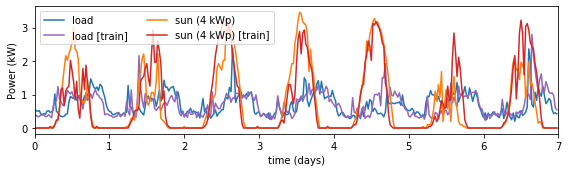

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5))
z = slice(0, 7*48)
ax.plot(td[z], P_load.iloc[z], label='load', color='tab:blue')
ax.plot(td[z], P_load_train.iloc[z], label='load [train]', color='tab:purple')
ax.plot(td[z], P_sun.iloc[z], label='sun ({} kWp)'.format(P_pvp), color='tab:orange')
ax.plot(td[z], P_sun_train.iloc[z], label='sun ({} kWp) [train]'.format(P_pvp), color='tab:red')

ax.legend(ncol=2)

ax.set(
    xlim = (0,7),
    xlabel = 'time (days)',
    ylabel = 'Power (kW)'   
)
fig.tight_layout()

## Rule based control with precharging

control rules:

1. during high price period (day and evening): “load following”
  * storage should follow the net load as much as possible: $P_{sto} = -P_{nl} = P_{sun} - P_{load} $
  * if empty, use grid instead
  * if full, curtail the excess of production
2. during low price period (night): “precharging”,
   i.e.  charge the battery to reach the energy set point $E_{sp}$
   at time $t_{sp}$ (which is 6:00 of that day).
  * $P_{sto}(k) = (E_{sp} - E_{sto}(k))/(t_{sp}-t(k))$
  * this rule should be limited to avoid wasting solar energy or create negative load shedding.
    this is expressed with the constraint is $P_{sto} \geq P_{nl}$ (storage power greater than net load) 
  * this rule should be limited by the usual power and energy limitation of the battery

Inputs: $P_{sun}$, $P_{load}$ storage state $E_{sto}$, hour of the day $h$

Parameters: target storage state $E_{sp}$ (the corresponding target hour is fixed)

Outputs: $P_{sto}$, $P_{grid}$, $P_{curt}$

Definitions:
* net load: $P_{nl} = P_{load} - P_{sun}$
* prechargind power: $ P_{sto}^{sp} = (E_{sp} - E_{sto}(k))/(t_{sp}-t(k))$

Load following algorithm
* if $P_{nl}>0$ (load > sun)
  * if battery not empty:
    battery discharge to follow net load $P_{sto} = -P_{nl} <0 $, $P_{grid} = 0$.
  * if battery is empty, use the grid instead: $P_{grid} = P_{nl}$
* if $P_{nl}<0$ (sun > load)
  * if battery not full: battery charges to absorbe net production $P_{sto} = -P_{nl} > 0$, $P_{grid} = 0$.
  * if battery is full, curtail the excess of production:
    $P_{curt} = -P_{nl}$, so that $P_{sun} - P_{curt} = P_{pv} = P_{load}$. $P_{grid} = 0$

Precharging algorithm.

*to be written*

In [47]:
def control(h, P_sun, P_load, E_sto, E_sp):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    # load following
    if h>= 6: 
        E_next = E_sto - P_nl*dt

        if P_nl>0: # (load > sun)
            E_next = E_next if E_next>0. else 0.
            P_sto = (E_next - E_sto)/dt # <0
            P_grid = P_nl + P_sto
        else:
            E_next = E_next if E_next<E_rated else E_rated
            P_sto = (E_next - E_sto)/dt # >0
            P_curt = -P_nl - P_sto
    # precharging
    else:
        P_sto = (E_sp - E_sto)/(6-h)
        # avoid negative load shedding
        if -P_sto > P_nl:
            P_sto = -P_nl
        P_grid = P_nl + P_sto
        # Todo: apply grid power limit
        
    return P_sto, P_grid, P_curt

In [48]:
h = 0
E_sp = 2
E_sto = 0
control(h, 0, 3, E_sto, E_sp)

(0.3333333333333333, 3.3333333333333335, 0)

In [49]:
E_sto = 1
control(h, 0, 3, E_sto, E_sp)

(0.16666666666666666, 3.1666666666666665, 0)

In [50]:
h = 5.5
E_sto = 1
control(h, 0, 3, E_sto, E_sp)

(2.0, 5.0, 0)

In [51]:
h = 5.5
E_sto = 3
control(h, 0, 3, E_sto, E_sp)

(-2.0, 1.0, 0)

In [52]:
h = 5.5
E_sto = 4
control(h, 0, 3, E_sto, E_sp)

(-3, 0, 0)

In [53]:
h = 5.5
E_sto = 5
control(h, 0, 3, E_sto, E_sp)

(-3, 0, 0)

### Simulation loop

In [170]:
P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

# Optimal value based on optimization with training data:
E_sp = 1.74 # kWh

for k in range(n):
    hk = (k/2) % 24
    P_sto[k], P_grid[k], P_curt[k] = control(hk, P_sun.values[k], P_load.values[k], E_sto[k], E_sp)
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

Collect all trajectory variables

In [171]:
traj = pd.DataFrame(
    data = {
        'E_sto': E_sto, # state 
        'P_sto': P_sto, # out

        'P_load_sp': P_load,
        'P_shed': np.zeros_like(P_load),
        'P_load': P_load,

        'P_sun' : P_sun,
        'P_curt': P_curt,
        'P_pv'  : P_sun - P_curt,

        'P_grid': P_grid,
        'c_grid': c_grid,
    }, index=t
)
traj.index.name = 't'
traj.head(3)

,E_sto,P_sto,P_load_sp,P_shed,P_load,P_sun,P_curt,P_pv,P_grid,c_grid
t,,,,,,,,,,
0.0,4.000000,-0.376667,0.520,0.0,0.520,0.0,0.0,0.0,0.143333,0.1
0.5,3.811667,-0.376667,0.528,0.0,0.528,0.0,0.0,0.0,0.151333,0.1
1.0,3.623333,-0.376667,0.496,0.0,0.496,0.0,0.0,0.0,0.119333,0.1


### Performance statistics

performance of the rule-based control (no precharging), for the reference:
* P_grid:     3.38 kWh/d
* C_grid:    0.563 €/d

Here we get 
* P_grid:     3.79 kWh/d
* C_grid:    **0.512 €/d** (i.e. -9.1%)

This is even better than SDP (0.523 €/day with present settings)

In [172]:
stats = bu.compute_stats(traj)
bu.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     2.35 kWh/d
P_pv:      13.26 kWh/d

P_sto:     0.025 kWh/d

P_grid:     3.79 kWh/d
C_grid:    0.512 €/d



In [176]:
.512/.563 -1

-0.09058614564831247

### Plots

TODO (nice to have): superposition with the classical rule based (without precharging)

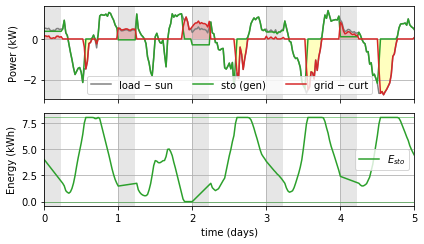

In [177]:
bu.plot_traj(traj[0:24*5], E_rated, show_P_sto=True);

#### State of Energy function of the hour of the day:

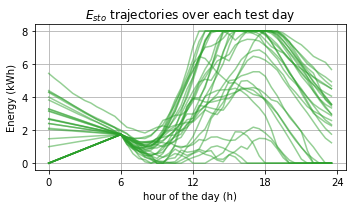

In [182]:
hod = np.arange(48)/2
E_sto_daily = traj.E_sto.values.reshape((-1,48))

fig, ax = plt.subplots(figsize=(5,3))

ax.plot(hod, E_sto_daily.T, color='tab:green', alpha=0.5)

ax.set(
    title='$E_{sto}$ trajectories over each test day',
    xlabel='hour of the day (h)',
    xticks=np.arange(5)*6,
    ylabel='Energy (kWh)'
)
ax.grid(True)
fig.tight_layout()
fig.savefig(f'E_sto_daily_rbopti.png', dpi=200, bbox_inches='tight')

#### Check ranges of decision variables

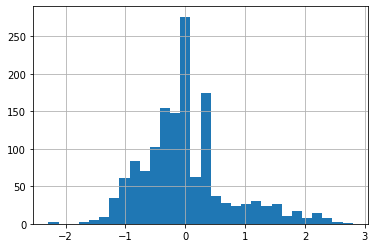

In [166]:
traj.P_sto.hist(bins=30)

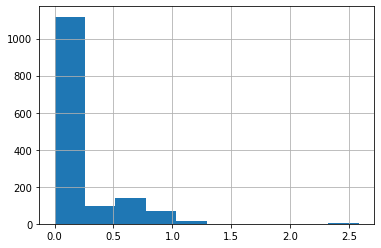

In [167]:
traj.P_grid.hist(bins=10)

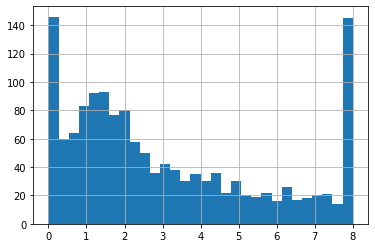

In [168]:
traj.E_sto.hist(bins=30)

## Optimization of the precharging parameter


### Cost function 
Simulation is embedded in a function which can test any `E_sp` value, to perform a grid search optimization.

In [82]:
def eval_cost(E_sp, subset='test'):
    """evaluate the performance of a given choice of E_sp
    
    Parameters
    ----------
    subset : string, optional
        select the data extract to load: 'test' for the test set,
        'train' for the training set.
    
    Returns the grid cost C_grid
    """
    P_sto = np.zeros(n)
    E_sto = np.zeros(n+1)
    P_grid = np.zeros(n)
    P_curt = np.zeros(n)

    E_sto[0]= E_rated/2

    for k in range(n):
        hk = (k/2) % 24
        if subset == 'test':
            P_sto[k], P_grid[k], P_curt[k] = control(hk, P_sun.values[k], P_load.values[k], E_sto[k], E_sp)
        elif subset == 'train':
            P_sto[k], P_grid[k], P_curt[k] = control(hk, P_sun_train.values[k], P_load_train.values[k], E_sto[k], E_sp)
        else:
            raise ValueError("`subset` should be either 'test' of 'train'")
        E_sto[k+1] = E_sto[k] + P_sto[k]*dt
        assert 0 <= E_sto[k+1] <= E_rated


    E_sto = E_sto[:-1]
    P_pv = P_sun - P_curt
    P_nl = P_load - P_sun
    
    C_grid = np.mean(P_grid * c_grid)*24
    return C_grid

In [88]:
eval_cost(2.2, 'test')

0.5176795260295257

In [169]:
eval_cost(2.2, 'train')

0.7878746153846143

### Evaluation on a grid: (takes ~3s)

In [117]:
nE = 300
E_sp_list = np.linspace(0, E_rated/2, nE)

In [119]:
Cg_test = np.zeros(nE)
Cg_train = np.zeros(nE)
for i, E_sp in enumerate(E_sp_list):
    Cg_train[i] = eval_cost(E_sp, 'train')
    Cg_test[i] = eval_cost(E_sp, 'test')

### Grid search optimization

with test data, best set point is 1.74 kWh (lower than the one used with SDP)

In [120]:
imin_train = Cg_train.argmin()
E_sp_train = E_sp_list[imin_train]

imin_test = Cg_test.argmin()
E_sp_test = E_sp_list[imin_test]
print('Best E_sp value:')
print(f'* train data: {E_sp_train:.2f} kWh')
print(f'* test data: {E_sp_test:.2f} kWh')

Best E_sp value:
* train data: 1.74 kWh
* test data: 1.30 kWh


In [126]:
%matplotlib inline

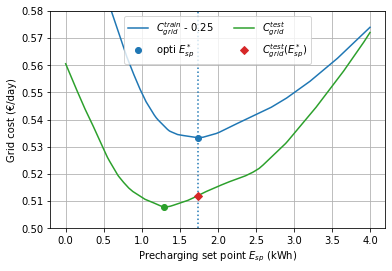

In [160]:
fig, ax1 = plt.subplots(1,1, sharex=True)

ax1.plot(E_sp_list, Cg_train-0.25, 'C0-', label='$C_{grid}^{train}$ - 0.25')
ax1.plot(E_sp_train, Cg_train.min()-0.25, 'C0o', label='opti $E_{sp}^*$')

ax1.plot(E_sp_list, Cg_test, 'C2-', label='$C_{grid}^{test}$')
ax1.axvline(E_sp_train, ls=':')
ax1.plot(E_sp_test, Cg_test.min(), 'C2o')
ax1.plot(E_sp_train, Cg_test[imin_train], 'C3D', label='$C_{grid}^{test}(E_{sp}^*)$')

ax1.set(
    xlabel='Precharging set point $E_{sp}$ (kWh)',
    ylabel='Grid cost (€/day)',
    ylim=(0.50, 0.58)
)
ax1.grid(True)
ax1.legend(ncol=2);

## Write results

In [183]:
bu.save_results('Python_rule-based-optim', params, stats, traj)

result files for method 'Python_rule-based-optim' written!
